In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests

# Data Sources
Ideally, I would like to get data from:
- Reddit episode discussions
    - upvotes
    - number of comments
    - episode ratings through the surveys in episode discussion threads
- IMBD episode ratings
- MAL episode polls

The reddit upvotes and comments are more a measure of popularity than quality. However the episode ratings and polls are likely to be a good measure. Most people will rate episodes they enjoy highly, and will rate low the episodes they don't like. Some people will rate all episodes highly, and some will rate all lowly, that is just the nature of the internet.

In terms of audience, these measures are obviously pretty specific. They are limited to the type of people that participate in these sites, which is a very different audience to the total population that have watched DBZ. Ideally, if one wanted to get a measure of the 'best' DBZ episode with the widest possible sample population, one would include statistics such as TV viewership and media sales. But to keep this project manageable I'll restrict to just the listed data sources. As such, this data will only be representative of the interactive, online, English audience.

---

# Hypotheses
Based off my own internal biases and preconceptions, I reckon we'll get the following:
- Top rated episode is either during Gohan's fight with Perfect Cell, or during the Goku vs Vegeta fight in the Saiyan saga.
- Top episode in each arc is during the final fight, with the exception of the Frieza saga where it's the episode when Goku achieves super saiyan.
- Lowest rated episode will be a filler episode, maybe in the Garlic Jr arc.


# MyAnimeList (MAL)
MAL has an unofficial API, [Jikan](jikan.moe), that we can use to get data from MAL. First, we can get the episode titles and other info, then hopefully we can use it to get the voting data from the forums.

The entry for DBZ is [here](https://myanimelist.net/anime/813/Dragon_Ball_Z). All anime in MAL have a corresponding ID, and from the URL we see that the ID for DBZ is 813.

The below code gets data from Jikan.

In [2]:
MAL_ID = 813 # DBZ's ID in the MAL database

def jikan_query(url):
    MAX_PAGES = 1000 # if we reach MAX_PAGES, something might have gone wrong, 
    TIMEOUT = 1.0 # how long to wait before timing out
    JIKAN_URL = "https://api.jikan.moe/v4/"

    # get json from jikan
    request_list = [] # holds request objects
    page = 1
    print("Obtaining data from Jikan...")
    next_page_exists = True
    while page <= MAX_PAGES and next_page_exists:
        print("Getting page",page)

        try:
            # get data
            r = requests.get(JIKAN_URL + url + f"?page={page}",\
                            timeout=TIMEOUT)
        except requests.exceptions.Timeout:
            # exit loop if we time out
            print("Timed out on page",page)
            break

        # append request results to list
        if r.status_code == 200:
            print("Successfully got data")
            request_list.append(r)
            next_page_exists = r.json()["pagination"]["has_next_page"]
        else:
            # if we errored, print the data and break
            print(f"HTML ERROR CODE {r.status_code}")
            print(r.json())
            break

        page += 1

    if not next_page_exists:
        print("Reached last page")
    else:
        print("ended prematurely")
    
    return request_list

request_list = jikan_query(f"anime/{MAL_ID}/episodes")

Obtaining data from Jikan...
Getting page 1
Successfully got data
Getting page 2
Successfully got data
Getting page 3
Successfully got data
Reached last page


Now that we have out mal data, we need to append the pages then save it for later analysis.

In [3]:
# append data from different pages
mal_data = []
for r in request_list:
    mal_data = mal_data + r.json()['data']
mal_df = pd.DataFrame(mal_data)

# save to a csv
MAL_FILENAME = "data/MAL_data.csv"
mal_df.to_csv(MAL_FILENAME)
mal_df

,mal_id,url,title,title_japanese,title_romanji,aired,score,filler,recap,forum_url
0,1,https://myanimelist.net/anime/813/Dragon_Ball_...,The New Threat,ミニ悟空はおぼっちゃま！ボク悟飯です。,Mini Gokuu wa Obotchama! Boku Gohan Desu.,1989-04-26T00:00:00+00:00,4.2,False,False,https://myanimelist.net/forum/?topicid=13008
1,2,https://myanimelist.net/anime/813/Dragon_Ball_...,Reunions,史上最強の戦士は悟空の兄だった！,Shijou Saikyou no Senshi wa Gokuu no Ani Datta!,1989-05-03T00:00:00+00:00,4.4,False,False,https://myanimelist.net/forum/?topicid=13009
2,3,https://myanimelist.net/anime/813/Dragon_Ball_...,Unlikely Alliance,やった！これが地上最強のコンビだ！,Yatta! Kore ga Chijou Saikyou no Combo Da!,1989-05-10T00:00:00+00:00,4.5,False,False,https://myanimelist.net/forum/?topicid=13010
3,4,https://myanimelist.net/anime/813/Dragon_Ball_...,Piccolo's Plan,ピッコロの切り札！悟飯は泣きむしクン,Pikkolo no Kirifuda! Gohan wa Nakimushikun,1989-05-17T00:00:00+00:00,4.6,False,False,https://myanimelist.net/forum/?topicid=13011
4,5,https://myanimelist.net/anime/813/Dragon_Ball_...,Gohan's Rage,悟空死す！ラストチャンスは一度だけ,Gokuu Shisu! Last Chance wa Ichido Dake,1989-05-24T00:00:00+00:00,4.5,False,False,https://myanimelist.net/forum/?topicid=13007
...,...,...,...,...,...,...,...,...,...,...
286,287,https://myanimelist.net/anime/813/Dragon_Ball_...,Celebrations with Majin Buu,戻った平和！！正義の味方魔人ブウ！？,Modotta Heiwa!! Seigi no Mikata Majin Buu!?,1995-12-20T00:00:00+00:00,4.8,False,False,https://myanimelist.net/forum/?topicid=696097
287,288,https://myanimelist.net/anime/813/Dragon_Ball_...,He's Always Late,遅いぜ悟空！みんなでパーティ！！,Osoi ze Gokuu! Minna de Party!!,1996-01-10T00:00:00+00:00,4.5,True,False,https://myanimelist.net/forum/?topicid=696103
288,289,https://myanimelist.net/anime/813/Dragon_Ball_...,Granddaughter Pan,悟空おじいちゃん！私がパンよ！！,Gokuu Ojii-chan! Watashi ga Pan yo!!,1996-01-17T00:00:00+00:00,4.6,False,False,https://myanimelist.net/forum/?topicid=696113
289,290,https://myanimelist.net/anime/813/Dragon_Ball_...,Buu's Reincarnation,オイラはウーブ！今１０歳で元魔人！？,Oira wa Oob! Ima Jussai de Moto Majin!?,1996-01-24T00:00:00+00:00,4.6,False,False,https://myanimelist.net/forum/?topicid=696117


There we go, this gives a bunch of information. Most importantly:
- English and japanese episode titles
- Each episode's score from the forums
- Whether each episode is a filler or recap episode

This is great, especially the score data. I was worried that we would have to webscrape for that since it isn't listed in the Jikan documentation, but here it is. Makes my job a lot easier. However, it doesn't contain the number of votes in each poll. So instead, I'll go through each web page and find the number of votes in each poll. Then we can see how reliable this data is.

In [5]:
## Data is contained in MAL_data.csv, don't run this code again
# get number of participants in each survey
num_votes = {i:np.nan for i,ep in mal_df.iterrows()} # create dictionary for num of votes
import re
import time
from tqdm import tqdm

# iter through each episode to get number of votes
for i,ep in tqdm(mal_df.iterrows()):
    # get forum page
    r = requests.get(ep["forum_url"]+"&pollresults=1", timeout=5.0)
    
    # if it went through, get the votes out
    if r.status_code == 200:
        results = re.search("(\d+)( votes)", r.text) # use regex to match "## votes", which is how they appear on the page
        
        if results:
            # if we found a match, add it to the dict
            num_votes[i] = int(results.group(1))
        else:
            # if we didn't find a match, wait for human verification
            print(f"ep {i}: No matches found")
            print("--------------- returned text ---------------")
            print(r.text)
            cont = ""
            while cont not in ["y","n"]:
                cont = input("continue (y/n):")
            if cont == "n":
                break
            
        time.sleep(5)# gotta be respectful
    else:
        # if we couldn't find a web page, show the status code and print the response
        print(f"Error: HTML status code {r.status_code}")
        print("--------------- returned text ---------------")
        print(r.text)
        cont = ""
        while cont not in ["y","n"]:
            cont = input("continue (y/n):")
        if cont == "n":
            break

291it [29:33,  6.09s/it]


In [12]:
for i,ep in mal_df.iterrows():
    mal_df.loc[i,"poll_votes"] = num_votes[i]
# save to a csv
MAL_FILENAME = "data/MAL_data.csv"
mal_df.to_csv(MAL_FILENAME)
mal_df

,mal_id,url,title,title_japanese,title_romanji,aired,score,filler,recap,forum_url,poll_votes
0,1,https://myanimelist.net/anime/813/Dragon_Ball_...,The New Threat,ミニ悟空はおぼっちゃま！ボク悟飯です。,Mini Gokuu wa Obotchama! Boku Gohan Desu.,1989-04-26T00:00:00+00:00,4.2,False,False,https://myanimelist.net/forum/?topicid=13008,190
1,2,https://myanimelist.net/anime/813/Dragon_Ball_...,Reunions,史上最強の戦士は悟空の兄だった！,Shijou Saikyou no Senshi wa Gokuu no Ani Datta!,1989-05-03T00:00:00+00:00,4.4,False,False,https://myanimelist.net/forum/?topicid=13009,128
2,3,https://myanimelist.net/anime/813/Dragon_Ball_...,Unlikely Alliance,やった！これが地上最強のコンビだ！,Yatta! Kore ga Chijou Saikyou no Combo Da!,1989-05-10T00:00:00+00:00,4.5,False,False,https://myanimelist.net/forum/?topicid=13010,92
3,4,https://myanimelist.net/anime/813/Dragon_Ball_...,Piccolo's Plan,ピッコロの切り札！悟飯は泣きむしクン,Pikkolo no Kirifuda! Gohan wa Nakimushikun,1989-05-17T00:00:00+00:00,4.6,False,False,https://myanimelist.net/forum/?topicid=13011,77
4,5,https://myanimelist.net/anime/813/Dragon_Ball_...,Gohan's Rage,悟空死す！ラストチャンスは一度だけ,Gokuu Shisu! Last Chance wa Ichido Dake,1989-05-24T00:00:00+00:00,4.5,False,False,https://myanimelist.net/forum/?topicid=13007,79
...,...,...,...,...,...,...,...,...,...,...,...
286,287,https://myanimelist.net/anime/813/Dragon_Ball_...,Celebrations with Majin Buu,戻った平和！！正義の味方魔人ブウ！？,Modotta Heiwa!! Seigi no Mikata Majin Buu!?,1995-12-20T00:00:00+00:00,4.8,False,False,https://myanimelist.net/forum/?topicid=696097,39
287,288,https://myanimelist.net/anime/813/Dragon_Ball_...,He's Always Late,遅いぜ悟空！みんなでパーティ！！,Osoi ze Gokuu! Minna de Party!!,1996-01-10T00:00:00+00:00,4.5,True,False,https://myanimelist.net/forum/?topicid=696103,37
288,289,https://myanimelist.net/anime/813/Dragon_Ball_...,Granddaughter Pan,悟空おじいちゃん！私がパンよ！！,Gokuu Ojii-chan! Watashi ga Pan yo!!,1996-01-17T00:00:00+00:00,4.6,False,False,https://myanimelist.net/forum/?topicid=696113,38
289,290,https://myanimelist.net/anime/813/Dragon_Ball_...,Buu's Reincarnation,オイラはウーブ！今１０歳で元魔人！？,Oira wa Oob! Ima Jussai de Moto Majin!?,1996-01-24T00:00:00+00:00,4.6,False,False,https://myanimelist.net/forum/?topicid=696117,34


Got it, that should be all the data I need from MAL. Now when we need it we just load it like below:

In [38]:
MAL_FILENAME = "data/MAL_data.csv"
mal_df = pd.read_csv(MAL_FILENAME, index_col=0)
mal_df

,mal_id,url,title,title_japanese,title_romanji,aired,score,filler,recap,forum_url,poll_votes
0,1,https://myanimelist.net/anime/813/Dragon_Ball_...,The New Threat,ミニ悟空はおぼっちゃま！ボク悟飯です。,Mini Gokuu wa Obotchama! Boku Gohan Desu.,1989-04-26T00:00:00+00:00,4.2,False,False,https://myanimelist.net/forum/?topicid=13008,190
1,2,https://myanimelist.net/anime/813/Dragon_Ball_...,Reunions,史上最強の戦士は悟空の兄だった！,Shijou Saikyou no Senshi wa Gokuu no Ani Datta!,1989-05-03T00:00:00+00:00,4.4,False,False,https://myanimelist.net/forum/?topicid=13009,128
2,3,https://myanimelist.net/anime/813/Dragon_Ball_...,Unlikely Alliance,やった！これが地上最強のコンビだ！,Yatta! Kore ga Chijou Saikyou no Combo Da!,1989-05-10T00:00:00+00:00,4.5,False,False,https://myanimelist.net/forum/?topicid=13010,92
3,4,https://myanimelist.net/anime/813/Dragon_Ball_...,Piccolo's Plan,ピッコロの切り札！悟飯は泣きむしクン,Pikkolo no Kirifuda! Gohan wa Nakimushikun,1989-05-17T00:00:00+00:00,4.6,False,False,https://myanimelist.net/forum/?topicid=13011,77
4,5,https://myanimelist.net/anime/813/Dragon_Ball_...,Gohan's Rage,悟空死す！ラストチャンスは一度だけ,Gokuu Shisu! Last Chance wa Ichido Dake,1989-05-24T00:00:00+00:00,4.5,False,False,https://myanimelist.net/forum/?topicid=13007,79
...,...,...,...,...,...,...,...,...,...,...,...
286,287,https://myanimelist.net/anime/813/Dragon_Ball_...,Celebrations with Majin Buu,戻った平和！！正義の味方魔人ブウ！？,Modotta Heiwa!! Seigi no Mikata Majin Buu!?,1995-12-20T00:00:00+00:00,4.8,False,False,https://myanimelist.net/forum/?topicid=696097,39
287,288,https://myanimelist.net/anime/813/Dragon_Ball_...,He's Always Late,遅いぜ悟空！みんなでパーティ！！,Osoi ze Gokuu! Minna de Party!!,1996-01-10T00:00:00+00:00,4.5,True,False,https://myanimelist.net/forum/?topicid=696103,37
288,289,https://myanimelist.net/anime/813/Dragon_Ball_...,Granddaughter Pan,悟空おじいちゃん！私がパンよ！！,Gokuu Ojii-chan! Watashi ga Pan yo!!,1996-01-17T00:00:00+00:00,4.6,False,False,https://myanimelist.net/forum/?topicid=696113,38
289,290,https://myanimelist.net/anime/813/Dragon_Ball_...,Buu's Reincarnation,オイラはウーブ！今１０歳で元魔人！？,Oira wa Oob! Ima Jussai de Moto Majin!?,1996-01-24T00:00:00+00:00,4.6,False,False,https://myanimelist.net/forum/?topicid=696117,34


# IMDb
---
IMDb lists Dragon Ball Z [here](https://www.imdb.com/title/tt0121220), and has an individual rating for each episode , which is perfect for our purposes. IMDb has two listings for DBZ, one has later air dates and appears to be the dub. We will use the sub, as the dub dataset would be difficult to merge with the MAL database since it has different episode titles and airdates, and a different number of episodes

IMDb ratings are notably different to MAL ratings. Firstly, they have significantly more participants, usually in the thousands rather than the tens. Secondly, the final score is weighted to help prevent vote manipulation by bots. They don't share their method, so I'll just trust their final weighted average score.

IMDb does have an API, but it costs money to use. So I'll just scrape what we need. Scraping IMDb is a little more tricky than scraping MAL because of how the webpages are laid out, so I'll use beautifulsoup to do the heavy lifting.

In [72]:
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests

# list of dictionaries to store data in
IMDb_data = []
# get page data
URL = f"https://www.imdb.com/title/tt0121220/episodes"
page = requests.get(URL)

# if we run into a problem do stuff
if page.status_code != 200:
    # if we couldn't load right, show the status code and print the response
    print(f"Error: HTML status code {page.status_code}")
    print("URL:",URL)
    print("--------------- returned text ---------------")
    print(page.text)
    cont = ""
    while cont not in ["y","n"]:
        cont = input("continue (y/n):")
else:
    # process with BeautifulSoup
    print("- page loaded")
    soup = BeautifulSoup(page.content, "html.parser")
    # find div for each episode
    ep_info_html = soup.find_all("div", class_="info")

    # for each episode, extract the title, weighted average rating, total votes, and airdate
    print("- getting episodes")
    for ep in ep_info_html:
        title = ep.find("a", attrs={"itemprop":"name"}).text.strip()
        star_rating = float(ep.find("span", class_="ipl-rating-star__rating").text)
        total_votes = int(ep.find("span", class_="ipl-rating-star__total-votes").text[1:-1].replace(",",""))
        airdate = ep.find("div", class_="airdate").text.strip()

        # append dictionary holding data for this episode to the IMDb_data list
        IMDb_data.append({"title":title,\
                          "star_rating":star_rating,\
                          "total_votes":total_votes,\
                          "aired":airdate})

    print("Finished! Converting to DataFrame")
    IMDb_df = pd.DataFrame(IMDb_data) # convert to a Pandas DataFrame

- page loaded
- getting episodes
Finished! Converting to DataFrame


In [73]:
# find number of duplicates
print(f"Number of duplicate entries: {sum(IMDb_df.duplicated())}")

# save to a csv
print("Saving...")
IMDB_FILENAME = "data/IMDb_data.csv"
IMDb_df.to_csv(IMDB_FILENAME)
print("Saved")

Number of duplicate entries: 0
Saving...
Saved


Great, we have our IMDb data, and we've saved it to a csv file. Now let's match up the episodes to those in MAL. The episodes on IMDb are in order, so we should be able to match them up directly one to one. As a sanity check, let's make sure the first few letters of the romanji title are the same in both datasets. The following code prints the title out if the first few characters of the titles are different

In [139]:
num_characters_to_compare = 3
for i,row in compiled_df.iterrows():
    if row["title_romanji"][:num_characters_to_compare] != IMDb_df.loc[i,"title"][:num_characters_to_compare]:
        print(f"{i}: {row['title_romanji'][:10]}... -- {row['IMDb_title'][:10]}...")

6: Kyouryuu t... -- Kyôryû to ...
17: Shuuten He... -- Shûte~n he...
18: Juuryoku t... -- Jûryoku to...
21: Nna Baka n... -- N'na baka ...
28: Tousan Sug... -- Tôsan sugê...
41: Wakusei Fr... -- Wasusei Fu...
50: Yuuki Hyak... -- Yûki hyaku...
57: Freeza no ... -- Furîza no ...
62: Choumajuts... -- Chô majuts...
63: Moui Recoo... -- Môi Rikûmu...
82: Kyoufu Shi... -- Kyôfu shir...
86: Chou Kesse... -- Chô kessen...
88: Freeza Kyo... -- Furîza kyô...
91: Chou Tokud... -- Chô tokuda...
104: Freeza Yab... -- Furîza yab...
108: Kyoufu no ... -- Kyôfu no k...
113: Chou Kagek... -- Chô kageki...
114: Kiita ze C... -- Kîta ze ch...
118: Freeza wa ... -- Furîza wa ...
119: Freeza wo ... -- Furîza o i...
128: Vegeta Tsu... -- Bejîta tsu...
139: Jaaku no T... -- Jâku no ta...
142: Zouo to Ha... -- Zôo to hak...
144: Cell Tanjo... -- Seru tanjô...
155: Cell yo Hi... -- Seru yo hi...
160: Super Vege... -- Sûpâ Bejît...
161: Super Saiy... -- Sûpâ Saiya...
164: Super Trun... -- Sûpâ Toran...
174: Ce

These mostly seem fine, with the difference mostly being:
- Choice of romanization of names (e.g. 57: Freeza vs Furîza)
- Using extra letters vs accents (e.g. 6: Kyouryuu vs Kyôryû)

Some are of concern and need to be checked manually. These are indices 176, 181, 183, and 289

In [143]:
indices_to_check = [176, 181, 183, 289]
for i in indices_to_check:
    print(f"{i}: {mal_df.loc[i,'title_romanji']} -- {IMDb_df.loc[i,'title']}")

176: Shoubu da Gokuu!! Chou Kinpaku Cell Games  -- Shôbuda Gokû!! Chô kinpaku Seru Gêmu
181: Okore Gohan Nemureru Chikara wo Yobiokose  -- Ikare Gohan nemureru chikara o yobi okose
183: 18-gou Muzan!! Ugokidasu Ikari no Super Gohan  -- 16-gô muzan!! Ugokidasu ikari no Sûpâ Gohan
289: Oira wa Oob! Ima Jussai de Moto Majin!?  -- Oura wa Ûbu! Ima 10-sai de moto Majin!?


These are all fine, they all clearly match up. With index 183, MAL also lists the title starting with 16 in their episode page [here](https://myanimelist.net/anime/813/Dragon_Ball_Z/episode/184), so it is the same episode.

Now we know it's all good, let's combine the data into one DataFrame.

In [145]:
IMDb_df["aired"] = pd.to_datetime(IMDb_df["aired"]).dt.date
mal_df["aired"] = pd.to_datetime(mal_df["aired"]).dt.date
compiled_df = pd.DataFrame(data=mal_df, columns=["mal_id","title","title_romanji",\
                                                 "filler","recap",\
                                                 "score","poll_votes"])
compiled_df.rename(columns={"score":"MAL_score","poll_votes":"MAL_poll_votes"}, inplace=True)

compiled_df["IMDb_score"] = IMDb_df["star_rating"]
compiled_df["IMDb_total_votes"] = IMDb_df["total_votes"]

# save to a csv
print("Saving...")
COMPILED_FILENAME = "data/compiled_data.csv"
compiled_df.to_csv(COMPILED_FILENAME)
print("Saved")

compiled_df

Saving...
Saved


,mal_id,title,title_romanji,filler,recap,MAL_score,MAL_poll_votes,IMDb_score,IMDb_total_votes
0,1,The New Threat,Mini Gokuu wa Obotchama! Boku Gohan Desu.,False,False,4.2,190,7.3,1414
1,2,Reunions,Shijou Saikyou no Senshi wa Gokuu no Ani Datta!,False,False,4.4,128,7.6,1377
2,3,Unlikely Alliance,Yatta! Kore ga Chijou Saikyou no Combo Da!,False,False,4.5,92,7.6,1366
3,4,Piccolo's Plan,Pikkolo no Kirifuda! Gohan wa Nakimushikun,False,False,4.6,77,8.0,1374
4,5,Gohan's Rage,Gokuu Shisu! Last Chance wa Ichido Dake,False,False,4.5,79,7.9,1357
...,...,...,...,...,...,...,...,...,...
286,287,Celebrations with Majin Buu,Modotta Heiwa!! Seigi no Mikata Majin Buu!?,False,False,4.8,39,7.4,1227
287,288,He's Always Late,Osoi ze Gokuu! Minna de Party!!,True,False,4.5,37,7.1,1228
288,289,Granddaughter Pan,Gokuu Ojii-chan! Watashi ga Pan yo!!,False,False,4.6,38,6.9,1217
289,290,Buu's Reincarnation,Oira wa Oob! Ima Jussai de Moto Majin!?,False,False,4.6,34,6.8,1216


<AxesSubplot:xlabel='MAL_score', ylabel='IMDb_score'>

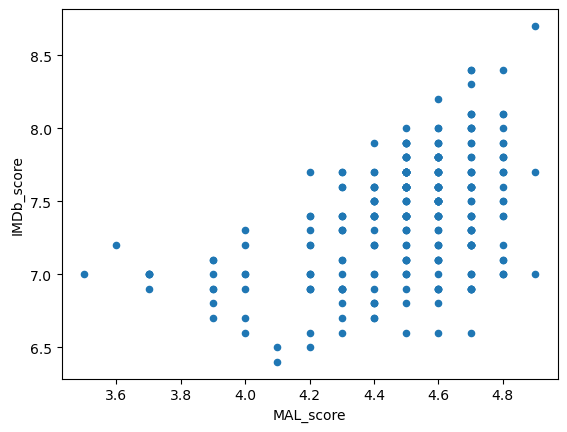

In [146]:
compiled_df.plot(kind="scatter",x="MAL_score",y="IMDb_score")